# Fractal dimension of Strava route
For a bit of fun, the idea is to estimate the fractal dimension of a Strava route. Start by looking at the theory of triangulation, when going around an idealised corner.


## Theory of going around corners - triangulation
Assume rider is travelling as speed s (in m/s) and that the corner is circular with radius r and turns through an angle $\phi$.
The number of GPS records equals the number of seconds taken to turn the corner $$t = r\phi / s$$
In each second, the rider will move through an angle $\theta$, where $$\theta = 2\pi * s / 2\pi r = s/r$$
The straight line distance between recorded points is $$d = 2r \sin(\theta/2) = 2r \sin(s/2r)$$
Distance around the corner recorded by GPS, estimated as a set of straight line segements $$Distance= td = r\phi /s * 2r \sin(s/2r) = 2 r^2\phi/s  \sin(s/2r)$$
Speed around the corner recorded by GPS, estimated as a set of straight line segements $$Speed= td/t = d =  2r \sin(s/2r) $$
Actual distance travelled $$Distance=r\phi $$
Triangulated estimate of distance travelled $$GPSdistance=2 r^2\phi/s  \sin(s/2r) =r\phi* (2r/s\sin(s/2r))$$
Actual speed $$Speed = s$$
Triangulated speed $$GPSspeed=d/t=2r \sin(s/2r)/ (r\phi / s) =s*(2r/s\sin(s/2r)) $$


Both distance and speed are underestimated by a factor $2r/s\sin(s/2r)$, which is always less than or equal to 1. When $s/2r$ is small, $sin(s/2r)\approx s/2r$. So the errors are small when riding slowly around a very wide corner, but the error becomes significant when riding around a sharp corner. For example, turning a tight 90-degree corner of radius 12.7m, you cover 20m on the road. When riding at 36km/h (10m/s) your GPS will tell you your speed is 35.1km/h and it will underestimate the distance by 0.5m. Riding, in contrast, at 18km/h (5m/s), your GPS will record 17.9km/h and lose only 0.1m of distance.<br>
Now imagine riding over a long twisty route. All those underestimates of distance will accumulate. A faster rider will record a noticeably shorter distance than a slowcoach!

![title](cornering.png)

In [1]:
import numpy as np
def GPSerror(s=10,r=25):
    return 2 * r / s * np.sin(s/2/r)
 

In [2]:
s, r, phi = 36, 12.7, np.pi/2
factor = GPSerror(s/3.6,r)
print(s*factor, r*phi*(factor), r*phi/(s/3.6), factor)

35.0771791267 19.4377395113 1.9949113350295185 0.974366086854


In [3]:
s, r, phi = 18, 12.7, np.pi/2
factor = GPSerror(s/3.6,r)
print(s*factor, r*phi*(factor), r*phi/(s/3.6), factor)

17.8839747951 19.8205244634 3.989822670059037 0.993554155282


## Comparison of wheel-based versus triangulated distances
I have a Garmin GSC-10 speed and cadence meter, so my Garmin 520 would have used this to record actual ground distance and ground speed. This is very close, but varies slightly from the triangulated distances

106732.9 106280.17080562847 -0.00424170236517


176       8.317013
195       5.426986
1252      4.753183
1294     11.495022
2350      3.180470
2448      2.788946
2837      4.366984
3103      3.820854
3665      4.987363
4977     12.118720
5659      5.999249
5660      4.051268
5661      4.182370
5662      4.051267
5663      4.182368
6597      2.267670
7375      2.623234
7527      6.657600
7995      3.463246
8053      6.140678
8190      6.576282
8191      4.912363
8192      4.974098
8193      4.912365
8194      4.877350
9987     35.601544
11411     7.338067
12863     6.564541
12931     5.505095
Name: dEst, dtype: float64

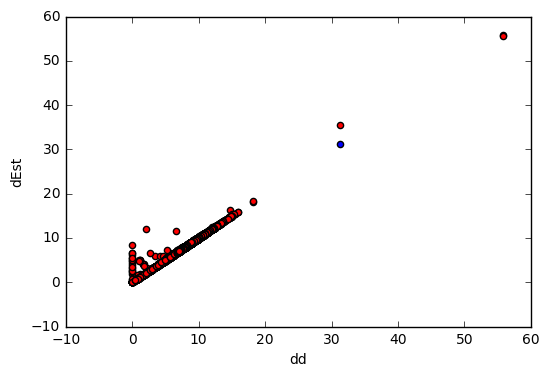

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from geopy.distance import vincenty

# Draw map does not seem to work inside a function??
import gmplot
import Strava_Download as strava

# This one should be exact because I didn't have a wheel based device
#activity_id=964415900

# This is a Windsor ride
activity_id=977124326

course = strava.get_strava_activity(activity_id)

s=0
dEst = [0] + [vincenty((course.lat[i],course.lon[i]), (course.lat[i+2**s],course.lon[i+2**s])).m for i in range(0,len(course)-2**s, 2**s)]
course['dEst'] = dEst
course['dd'] = course.distance.diff()
ax1=course.plot(kind='scatter',x='dd',y='dd')
ax2=course.plot(kind='scatter',x='dd',y='dEst',c='r',ax=ax1)

print(course.distance.max(),sum(dEst),sum(dEst)/course.distance.max()-1 )
course.dEst[abs(course.dd-course.dEst)>2]

Quite a few differences occur when the bike is not moving

## Fractal calculations
Using Richardson's method http://www.wahl.org/fe/HTML_version/link/FE4W/c4.htm#richardson
This started with just looking at the route in 2D: latitude and longitude. This measures the "twistiness" of the route. If circuits are performed, the algorithm only makes sense for a single lap.


In [5]:

API_KEY = strava.get_token(tokenFile = '/Users/Gavin/Gavin/Tokens/googleToken.txt')

def fractal(courseFile = 'Barcombe.csv'):
    """ Loads a course from a csv of an activity file 
    The calculation uses the lat and lon fields only"""
    course=pd.read_csv(courseFile,skipinitialspace=True) # Tour de Richmond Park
    lc = len(course)
    length = []
    height = []
    n = int(np.log2(lc/4))
    for s in np.arange(n):
        # Sum of step sizes 2**s
        l = sum([vincenty((course.lat[i],course.lon[i]), (course.lat[i+2**s],course.lon[i+2**s])).m for i in range(0,len(course)-2**s, 2**s)])
        # Add on the final stub from the last multiple of 2**s up to the end of the course
        l += vincenty((course.lat.iloc[-1],course.lon.iloc[-1]), (course.lat.iloc[-1-(lc%2**s)],course.lon.iloc[-1-(lc%2**s)])).m 
        length += [l]
    x, y = np.log(1/2**(np.arange(n))),np.log(length)
    #plt.scatter(x,y,)
    slopel = ((x*y).mean() - x.mean()*y.mean()) / ((x*x).mean() - x.mean()**2)
    fractalDimension = 1 + slopel
    #print('Fractal dimension of length = {L:.2f}'.format(L = fractalDimension))
    return course, fractalDimension




In [6]:
coursefile = strava.createCSVofStravaSegment('1054225')
course, fractalDimension = fractal(coursefile)
print('Fractal dimension of length = {L:.2f}'.format(L = fractalDimension))
gmap = gmplot.GoogleMapPlotter(course.lat.mean(), course.lon.mean(), 14, API_KEY)
gmap.plot(course.lat, course.lon, 'cornflowerblue', edge_width=4)
gmap.circle(course.lat.iloc[-1], course.lon.iloc[-1], 60, color='red',title='Finish')
gmap.draw('mymap.html')
from IPython.display import IFrame, display
IFrame('mymap.html', width=700, height=500)


Fractal dimension of length = 1.01


In [7]:
coursefile = strava.createCSVofStravaSegment('1621682')
course, fractalDimension = fractal(coursefile)
print('Fractal dimension of length = {L:.2f}'.format(L = fractalDimension))
gmap = gmplot.GoogleMapPlotter(course.lat.mean(), course.lon.mean(), 12, API_KEY)
gmap.plot(course.lat, course.lon, 'cornflowerblue', edge_width=4)
gmap.circle(course.lat.iloc[-1], course.lon.iloc[-1], 60, color='red',title='Finish')
gmap.draw('mymap.html')
from IPython.display import IFrame, display
IFrame('mymap.html', width=700, height=500)


Fractal dimension of length = 1.11


Try a really stupid on https://www.strava.com/activities/246510956
I created a CSV file locally from GPX file downloaded from Strava page


In [8]:
# CSV file created locally from downloaded GPX file
course, fractalDimension = fractal('Art.csv')
print('Fractal dimension of length = {L:.2f}'.format(L = fractalDimension))

gmap = gmplot.GoogleMapPlotter(course.lat.mean(), course.lon.mean(), 14, API_KEY)
gmap.plot(course.lat, course.lon, 'cornflowerblue', edge_width=2)
gmap.circle(course.lat.iloc[-1], course.lon.iloc[-1], 60, color='red',title='Finish')
gmap.draw('mymap.html')
from IPython.display import IFrame, display
IFrame('mymap.html', width=700, height=500)



Fractal dimension of length = 1.34


## Accounting for altitude
It's also possible to consider altitude, to estimate the "hilliness" of a route. I decided to keep these separate, rather than considering the route in 3D because gravity breaks the symmetry: a hilly course is much more difficult than a twisty course. 


It turns out that this does not work very well because the altitude variation of the Sellaronda ends up having a much lower fractal dimension than a flat Surrey course!

In [9]:
def fractal3D(courseFile = 'Barcombe.csv'):
    """ Loads a course from a csv of an activity file 
    The calculation uses the lat and lon fields only"""
    course=pd.read_csv(courseFile,skipinitialspace=True) # Tour de Richmond Park
    lc = len(course)
    length = []
    height = []
    n = int(np.log2(lc/4))
    for s in np.arange(n):
        # Sum of step sizes 2**s
        l = sum([vincenty((course.lat[i],course.lon[i]), (course.lat[i+2**s],course.lon[i+2**s])).m for i in range(0,len(course)-2**s, 2**s)])
        h = sum([abs(-course.altitude[i] + course.altitude[i+2**s]) for i in range(0,len(course)-2**s, 2**s)])
        # Add on the final stub from the last multiple of 2**s up to the end of the course
        l += vincenty((course.lat.iloc[-1],course.lon.iloc[-1]), (course.lat.iloc[-1-(lc%2**s)],course.lon.iloc[-1-(lc%2**s)])).m 
        h += abs(-course.altitude.iloc[-1] + course.altitude.iloc[-1-(lc%2**s)]) 
        length += [l]
        height += [h/2]
    x, y = np.log(1/2**(np.arange(n))),np.log(length)
    plt.scatter(x,y,)
    plt.title('Length')
    plt.show()
    slopel = ((x*y).mean() - x.mean()*y.mean()) / ((x*x).mean() - x.mean()**2)
    x, y = np.log(1/2**(np.arange(n))),np.log(height)
    plt.scatter(x,y)
    plt.title('Height')
    plt.show()
    slopeh = ((x*y).mean() - x.mean()*y.mean()) / ((x*x).mean() - x.mean()**2)
    course.altitude.plot()
    print('Fractal degrees: length = {L:.2f} height = {H:.2f}'.format(L = 1 + slopel, H = 1 + slopeh))
    return course


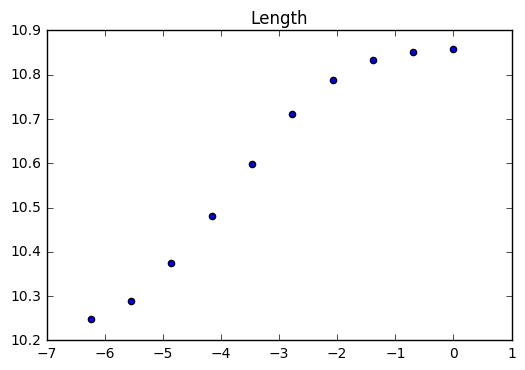

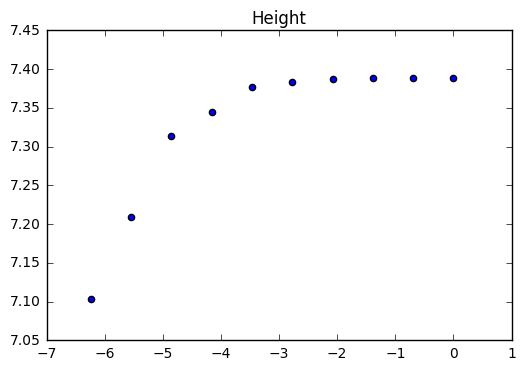

Fractal degrees: length = 1.11 height = 1.04


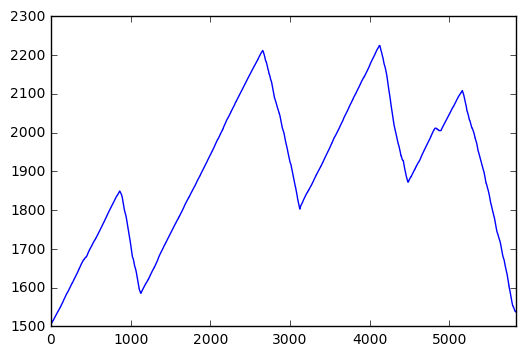

In [10]:
course = fractal3D(coursefile)

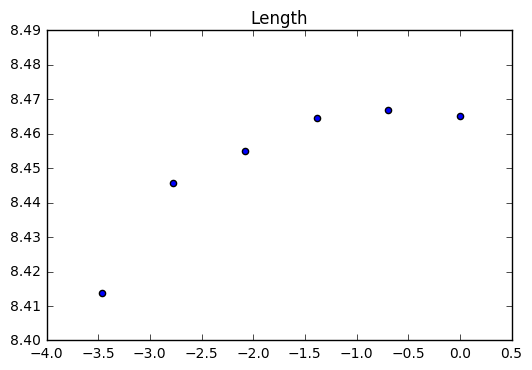

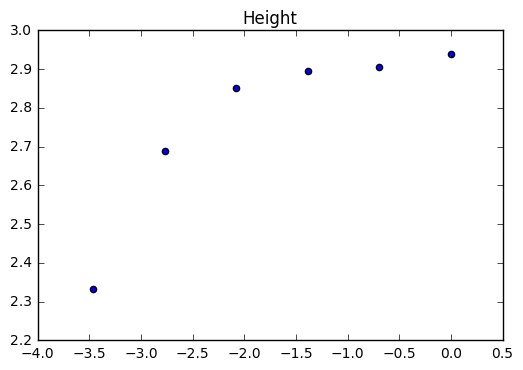

Fractal degrees: length = 1.01 height = 1.15


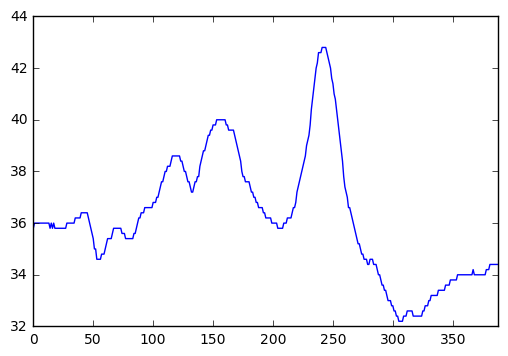

In [11]:
coursefile = strava.createCSVofStravaSegment('1054225')
course = fractal3D(coursefile)

<img scr='corner.png' \img>